In [1]:
import numpy as np
from numpy.linalg import norm
from math import *
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
from random import random
from scipy.spatial import ConvexHull
from matplotlib import path
import time

% matplotlib inline

Helper functions

In [2]:
def isCollisionFreeVertex(obstacles, xy):
    collFree = True

    for obstacle in obstacles:
        hull = path.Path(obstacle)
        collFree = not hull.contains_points([xy])
        if hull.contains_points([xy]):
#             print 'collision'
            return collFree

    return collFree

In [3]:
def isCollisionFreeEdge(obstacles, closest_vert, xy):
    closest_vert = np.array(closest_vert); xy = np.array(xy)
    collFree = True
    l = norm(closest_vert - xy)
    map_resolution = 0.001; M = int(l / map_resolution)
    if M <= 2: M = 3
    t = np.linspace(0,1,M)
    for i in range(1,M-1):
        p = (1-t[i])*closest_vert + t[i]*xy # calculate configuration
        collFree = isCollisionFreeVertex(obstacles, p) 
        if collFree == False: return False

    return collFree

In [4]:
def closestVertex(rrt_verts, xy):
    distance = np.zeros(len(rrt_verts[0,:]))
    for k in range( len(rrt_verts[0,:]) ):
        distance[k] = sqrt((xy[0] - rrt_verts[0,k])**2 + (xy[1] - rrt_verts[1,k])**2)
    dmin = min(distance)
    ind_min = distance.tolist().index(dmin)
    
    closest_vert = rrt_verts[:,ind_min]

    return closest_vert, ind_min

RRT algorithm

In [7]:
def draw_map():
    # Obstacles. An obstacle is represented as a convex hull of a number of points. 
    # First row is x, second is y (position of vertices)
    w = 0.2
    obstacles = [
                  np.array([[0, 0], [1, 0], [1, 0.1], [0, w]]),
                  np.array([[0, 0], [w, 0.2], [0.1, 2], [0.0, 2.0]]),
                  np.array([[0, 2-w], [1, 2], [1, 2+w], [0, 2+w]]),
                  np.array([[1-w, 0], [1+w, 0], [1+w, 1], [1, 1]]),
                  np.array([[1-w, 2+w], [1+w, 2+w], [1+w, 1.5], [1, 1.5]]),
                  np.array([[0.8, 1], [1+w, 1], [1+w, 1+w], [0.8, 1+w]]),
                  np.array([[0.8, 1.5], [1+w, 1.5], [1+w, 1.5+w], [0.8, 1.5+w]])
                ]

    # Bounds on world
    world_bounds_x = [-2.5, 2.5]
    world_bounds_y = [-2.5, 2.5]


    # Draw obstacles
    fig = plt.figure(figsize=(10, 10))
    plt.grid()
    ax = plt.gca()
    ax.set_xlim(world_bounds_x)
    ax.set_ylim(world_bounds_y)
    for k in range(len(obstacles)):
        ax.add_patch( Polygon(obstacles[k]) )
    return obstacles

Reached the goal after 3.60 seconds:
Number of iterations passed: 481 / 5000
RRT length:  242


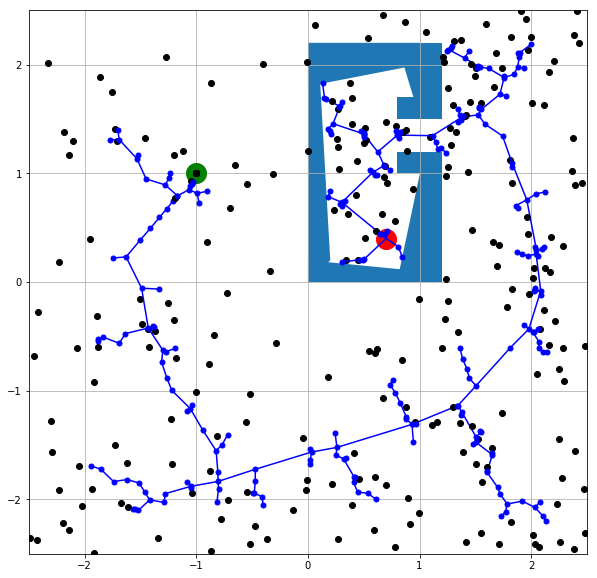

In [8]:
# Initialization
visualize = 1
maxiters  = 5000

obstacles = draw_map()

# Start and goal positions
xy_start = np.array([0.7, 0.4]); plt.plot(xy_start[0],xy_start[1],'bo',color='red', markersize=20)
xy_goal =  np.array([-1.0, 1.0]);  plt.plot(xy_goal[0], xy_goal[1], 'bo',color='green',markersize=20)

# Initialize RRT. The RRT will be represented as a 2 x N list of points.
# So each column represents a vertex of the tree.
rrt_verts = xy_start[np.newaxis].T
nearGoal = False # This will be set to true if goal has been reached
minDistGoal = 0.1 # Convergence criterion: success when the tree reaches within 0.25 in distance from the goal.
d = 0.20 # Extension parameter: this controls how far the RRT extends in each step.

# RRT algorithm
indexes = []
start_time = time.time()
iters = 0
while not nearGoal and iters < maxiters:
    # Sample point
    rnd = random()
    # With probability 0.05, sample the goal. This promotes movement to the goal.
    if rnd < 0.05:
        xy = xy_goal
    else:
        # Sample (uniformly) from space (with probability 0.95). The space is defined
        # with the bounds world_bounds_x and world_bounds_y defined above.
        # So, the x coordinate should be sampled in the interval
        # world_bounds_x=2.5 and the y coordinate from world_bounds_y=2.5.
        xy = np.array([random()*5-2.5, random()*5-2.5]) # Should be a 2 x 1 vector
    # Check if sample is collision free
    collFree = isCollisionFreeVertex(obstacles, xy)
    # If it's not collision free, continue with loop
    if not collFree:
        iters += 1
        continue

    # If it is collision free, find closest point in existing tree. 
    closest_vert, ind_min = closestVertex(rrt_verts, xy)
    indexes.append(ind_min)
    
    # Extend tree towards xy from closest_vert. Use the extension parameter
    # d defined above as your step size. In other words, the Euclidean
    # distance between new_vert and closest_vert should be d.
    new_vert = closest_vert + d*(xy - closest_vert)

    # Check if new vertice is in collision
    collFree = isCollisionFreeEdge(obstacles, closest_vert, new_vert)
    # If it's not collision free, continue with loop
    if not collFree:
        iters += 1
        continue
    
    if visualize:
        plt.plot(xy[0], xy[1], 'ro', color='k')
        plt.plot(new_vert[0], new_vert[1], 'bo',color = 'blue', markersize=5) # VERTICES
        plt.plot([closest_vert[0], new_vert[0]], [closest_vert[1], new_vert[1]], color='blue') # EDGES


    # If it is collision free, add it to tree    
    rrt_verts = np.hstack([rrt_verts, new_vert[np.newaxis].T])
#     print(rrt_verts.shape[1])

    # Check if we have reached the goal
    if norm(np.array(xy_goal) - np.array(new_vert)) < minDistGoal:
        end_time = time.time()
        nearGoal = True
        print 'Reached the goal after %.2f seconds:' % (end_time - start_time)

    iters += 1

print 'Number of iterations passed: %d / %d' %(iters, maxiters)
print 'RRT length: ', rrt_verts.shape[1]